Importiamo tutte le librerie che ci interessano

In [ ]:
import gym
import random
import numpy as np
from keras.layers import Input, Conv2D, Dense, MaxPooling2D , Flatten
from keras.models import Model, Sequential, load_model
from collections import deque
from keras.optimizers import Adam
import keras
import matplotlib.pyplot as plt

Creo l'ambiente SpaceInvaders-vo

In [ ]:
env = gym.make('SpaceInvaders-v0')

Creiamo la nostra rete neurale

In [34]:
class DQN:
    def __init__(self, input_shape, output_shape, discount=0.99, update_target_every=10, memory_size=2000):
        self.input_shape=input_shape
        self.output_shape=output_shape
        self.discount=discount
        self.update_target_every=update_target_every
        self.policy_net=self.create_model()
        self.memory=deque(maxlen=memory_size)
        self.target_counter=0 
    
    def create_model(self):
        model=Sequential()
        model.add(Conv2D(input_shape=self.input_shape, filters=16, kernel_size=(8,8), strides=(4,4), padding="valid", 
                        activation="relu", use_bias=True,))
        model.add(Conv2D(filters=16, kernel_size=(4,4), strides=(2,2), padding="valid", 
                       activation="relu", use_bias=True,))
        #model.add(Conv2D(filters=32, kernel_size=(2,2), padding="valid", 
        #                activation="relu", use_bias=True,))
        model.add(Flatten())
        model.add(Dense(128, activation="relu"))
        model.add(Dense(self.output_shape, activation="softmax"))
        adm=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
        model.compile(loss="mse", optimizer=adm, metrics=["accuracy"])
        return model
    
    def get_action (self,state):
        action_prob= self.policy_net.predict(state)
        return action_prob        

Definiamo tre metodi per preprocessare la nostra immagine croppandola e portandola ad una scala di grigi

In [35]:
def to_greyscale(img):
        return np.mean(img , axis=2).astype(np.uint8)

In [36]:
def downsample(img):
        return img[::2 , ::2]

In [37]:
def preprocess(img):
        return to_greyscale(downsample(img))

Definiamo un metodo per trasformare ogni ricompensa in (-1, 0, +1)

In [7]:
def transform_reward(reward):
    return np.sign(reward)

In [8]:
#?????????
def fit_batch(model , gamma , start_states , actions , rewards , next_states , is_terminal):
    next_Q_values = model.predict([next_states , np.ones(actions.shape)])
    next_Q_values[is_terminal]=0
    Q_values = rewards + gamma * np.max(next_Q_values , axis=1)
    model.fit([start_states , actions] , actions*Q_values[:, None] , nb_epoch=1 , batch_size=len(start_states) , verbose=0)

In [9]:
def q_iteration(env, model , state , iteration , memory):
    epsilon = get_epsilon_for_iteration(iteration)
    if random.random() < epsilon:
        action = env.action_space.sample()
    else:
        action = choose_best_action(model , state)
    
    new_frame , reward , is_done , _ = env.step(action)
    memory.add(state , action , new_frame , reward , is_done)
    batch = memory.sample_batch(32)
    fit_batch(model , batch)

In [11]:
class Memory:
    def __init__(self , memory = [] , maxsize = 10000):
            self.iteration = 0
            self.memory = memory
            self.maxsize = maxsize

In [12]:
def iteration(env  , model  , mem):
    env.reset()
    epsilon =  (0.995)**(mem.iteration+1)
    o,r,d,i = env.step(0)
    env.render()
    processed_state = preprocess(o)
    processed_state = processed_state.reshape((1,105,80,1))
    mem.memory = []
    for i in range(mem.maxsize):
        if  random.random() < epsilon:
            ac = env.action_space.sample()
        else:
            ac = np.argmax(model.policy_net.predict(processed_state))
        next_state,reward,done,info = env.step(ac)
        if done:
            next_processed_state = preprocess(next_state)
            next_processed_state = next_processed_state.reshape((1,105,80,1))
            mem.memory.append((processed_state,ac  , next_processed_state , transform_reward(reward), done ))
            break
        env.render()
        next_processed_state = preprocess(next_state)
        next_processed_state = next_processed_state.reshape((1,105,80,1))
        mem.memory.append((processed_state,ac  , next_processed_state , transform_reward(reward), done ))
        processed_state=next_processed_state
    mem.iteration=mem.iteration+1   

In [67]:
mem = Memory()
dqn = DQN((105,80,1),6)

In [39]:
dqn.policy_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 25, 19, 16)        1040      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 8, 16)         4112      
_________________________________________________________________
flatten_2 (Flatten)          (None, 1408)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               180352    
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 774       
Total params: 186,278
Trainable params: 186,278
Non-trainable params: 0
_________________________________________________________________


In [68]:
iteration(env , dqn , mem)

In [41]:
env.close()

In [42]:
len(mem.memory)

512

In [43]:
iteration(env , dqn , mem)

In [44]:
len(mem.memory)

835

In [45]:
mem.iteration

2

In [46]:
dqn.policy_net.predict(mem.memory[0][0])

array([[2.92069746e-08, 6.01584998e-06, 1.60803907e-07, 1.53300334e-05,
        9.99978542e-01, 1.36049115e-11]], dtype=float32)

In [47]:
for index, _  in enumerate(mem.memory):
    print(index , dqn.policy_net.predict(mem.memory[index][0]))

0 [[2.92069746e-08 6.01584998e-06 1.60803907e-07 1.53300334e-05
  9.99978542e-01 1.36049115e-11]]
1 [[2.92069746e-08 6.01584998e-06 1.60803907e-07 1.53300334e-05
  9.99978542e-01 1.36049115e-11]]
2 [[2.92069746e-08 6.01584998e-06 1.60803907e-07 1.53300334e-05
  9.99978542e-01 1.36049115e-11]]
3 [[2.0190253e-08 4.4959056e-06 2.0066831e-07 1.6791959e-05 9.9997842e-01
  1.4805726e-11]]
4 [[2.0190253e-08 4.4959056e-06 2.0066831e-07 1.6791959e-05 9.9997842e-01
  1.4805726e-11]]
5 [[2.92069746e-08 6.01584998e-06 1.60803907e-07 1.53300334e-05
  9.99978542e-01 1.36049115e-11]]
6 [[2.92069746e-08 6.01584998e-06 1.60803907e-07 1.53300334e-05
  9.99978542e-01 1.36049115e-11]]
7 [[2.92069746e-08 6.01584998e-06 1.60803907e-07 1.53300334e-05
  9.99978542e-01 1.36049115e-11]]
8 [[2.0190253e-08 4.4959056e-06 2.0066831e-07 1.6791959e-05 9.9997842e-01
  1.4805726e-11]]
9 [[2.0190253e-08 4.4959056e-06 2.0066831e-07 1.6791959e-05 9.9997842e-01
  1.4805726e-11]]
10 [[2.0190253e-08 4.4959056e-06 2.0066831e-

157 [[1.6826065e-04 2.4356192e-02 1.9879358e-02 9.3382396e-02 8.6173540e-01
  4.7832512e-04]]
158 [[3.0526344e-04 1.9261632e-02 2.3071470e-02 8.7679751e-02 8.6888111e-01
  8.0084847e-04]]
159 [[3.0526344e-04 1.9261632e-02 2.3071470e-02 8.7679751e-02 8.6888111e-01
  8.0084847e-04]]
160 [[3.0526344e-04 1.9261632e-02 2.3071470e-02 8.7679751e-02 8.6888111e-01
  8.0084847e-04]]
161 [[2.9212100e-04 2.1902505e-02 3.2800883e-02 9.3954638e-02 8.5017020e-01
  8.7962352e-04]]
162 [[6.3335269e-06 4.1290943e-04 1.7037016e-04 5.4928780e-05 9.7939271e-01
  1.9962799e-02]]
163 [[1.1317119e-05 1.9706381e-04 7.4094586e-04 4.2264699e-05 9.5546377e-01
  4.3544631e-02]]
164 [[2.8149025e-06 1.1204707e-04 9.9946151e-04 2.0425592e-05 9.5683056e-01
  4.2034764e-02]]
165 [[4.8922034e-06 1.2961886e-04 9.1632083e-04 2.3964049e-05 9.5004195e-01
  4.8883259e-02]]
166 [[6.8539671e-06 1.5327362e-04 9.5460867e-04 2.3534765e-05 9.3207163e-01
  6.6790193e-02]]
167 [[2.1427129e-06 8.6410037e-05 5.8989070e-04 7.4351110e-0

250 [[9.8474584e-07 5.5892233e-02 1.1603488e-04 2.0699406e-02 9.2328984e-01
  1.5653126e-06]]
251 [[7.0140339e-07 4.7943838e-02 1.2745330e-04 2.3607189e-02 9.2831945e-01
  1.3942941e-06]]
252 [[9.8474584e-07 5.5892233e-02 1.1603488e-04 2.0699406e-02 9.2328984e-01
  1.5653126e-06]]
253 [[7.0140339e-07 4.7943838e-02 1.2745330e-04 2.3607189e-02 9.2831945e-01
  1.3942941e-06]]
254 [[7.0140339e-07 4.7943838e-02 1.2745330e-04 2.3607189e-02 9.2831945e-01
  1.3942941e-06]]
255 [[9.8474584e-07 5.5892233e-02 1.1603488e-04 2.0699406e-02 9.2328984e-01
  1.5653126e-06]]
256 [[7.0140339e-07 4.7943838e-02 1.2745330e-04 2.3607189e-02 9.2831945e-01
  1.3942941e-06]]
257 [[9.8474584e-07 5.5892233e-02 1.1603488e-04 2.0699406e-02 9.2328984e-01
  1.5653126e-06]]
258 [[7.0140339e-07 4.7943838e-02 1.2745330e-04 2.3607189e-02 9.2831945e-01
  1.3942941e-06]]
259 [[7.0140339e-07 4.7943838e-02 1.2745330e-04 2.3607189e-02 9.2831945e-01
  1.3942941e-06]]
260 [[9.8474584e-07 5.5892233e-02 1.1603488e-04 2.0699406e-0

340 [[9.8446221e-04 4.7070098e-01 4.7412981e-05 3.2026365e-01 1.7507946e-01
  3.2924037e-02]]
341 [[6.2928785e-04 5.1546621e-01 1.4707669e-04 2.7459380e-01 1.6962062e-01
  3.9542940e-02]]
342 [[9.3436032e-04 4.6575645e-01 1.4823377e-04 2.9573163e-01 2.0070444e-01
  3.6724836e-02]]
343 [[0.00065233 0.22108036 0.00056933 0.21874261 0.51662564 0.0423297 ]]
344 [[7.9617812e-04 1.8754153e-01 3.1914195e-04 1.9939710e-01 5.8339626e-01
  2.8549761e-02]]
345 [[4.3316945e-04 1.4734778e-01 1.4610395e-04 4.9540520e-01 3.0991361e-01
  4.6754077e-02]]
346 [[3.6183262e-04 1.6292360e-01 1.4788659e-04 2.0524399e-01 5.3785801e-01
  9.3464769e-02]]
347 [[1.9811076e-04 2.0008795e-01 2.5556126e-04 3.9982420e-01 3.3754632e-01
  6.2087823e-02]]
348 [[3.5268028e-04 2.1755277e-01 2.1544349e-04 4.7918567e-01 2.7254096e-01
  3.0152559e-02]]
349 [[4.6323964e-04 3.0157700e-01 1.7192541e-04 4.2351031e-01 2.4870540e-01
  2.5572117e-02]]
350 [[2.1708140e-01 1.5541100e-02 3.2552175e-04 1.3008511e-02 5.9051764e-01
  1.

483 [[3.0458565e-03 5.9399568e-02 1.8017179e-08 9.1290617e-01 2.4316942e-02
  3.3146981e-04]]
484 [[3.7416120e-03 4.2934284e-02 1.9655204e-08 9.3176383e-01 2.1191258e-02
  3.6902222e-04]]
485 [[3.7416120e-03 4.2934284e-02 1.9655204e-08 9.3176383e-01 2.1191258e-02
  3.6902222e-04]]
486 [[1.4803625e-02 2.8554621e-01 8.8410800e-08 5.3080148e-01 1.6814008e-01
  7.0851727e-04]]
487 [[1.46900874e-03 1.89736001e-02 1.39673846e-08 9.66187060e-01
  1.23705175e-02 9.99877579e-04]]
488 [[1.4708933e-03 3.6386289e-02 1.2969606e-08 9.2740542e-01 3.4504969e-02
  2.3234927e-04]]
489 [[1.8353021e-03 1.6099250e-02 7.3216158e-09 9.7438103e-01 7.3965038e-03
  2.8788624e-04]]
490 [[3.9509959e-03 7.9845548e-02 2.4935721e-08 8.8197964e-01 3.2704700e-02
  1.5190804e-03]]
491 [[1.8136907e-02 1.1847939e-01 2.2526037e-07 6.5767640e-01 1.9240613e-01
  1.3300948e-02]]
492 [[1.06208194e-02 9.98094976e-02 1.03148835e-07 7.76116431e-01
  1.10719927e-01 2.73330417e-03]]
493 [[5.5044022e-04 1.0114911e-03 9.4856233e-07 

638 [[2.2339435e-04 1.1036260e-03 4.0381961e-02 6.1788805e-02 8.7439293e-01
  2.2109283e-02]]
639 [[1.7395827e-04 1.4986545e-03 2.4785265e-02 3.9154705e-02 9.2610407e-01
  8.2833050e-03]]
640 [[0.00152883 0.00093447 0.00631267 0.3899305  0.59936434 0.00192926]]
641 [[8.4644952e-04 5.2013225e-04 2.8557638e-03 4.3972313e-01 5.5372572e-01
  2.3287868e-03]]
642 [[1.7720836e-04 1.7773602e-03 2.0358743e-02 1.4216124e-01 8.2923263e-01
  6.2928637e-03]]
643 [[1.1775163e-04 8.3222386e-04 5.4165823e-03 2.3851825e-02 9.6789128e-01
  1.8902720e-03]]
644 [[8.13125353e-03 1.07164895e-04 1.15908144e-04 1.34162162e-03
  9.89986479e-01 3.17539088e-04]]
645 [[2.9434612e-01 2.9308731e-05 5.4489722e-04 1.1633624e-02 6.8958509e-01
  3.8608948e-03]]
646 [[3.52455899e-02 1.05992294e-04 2.84782785e-04 6.04865188e-03
  9.55130219e-01 3.18472926e-03]]
647 [[6.3323458e-03 3.0777068e-05 2.1507719e-04 1.1933956e-03 9.9143267e-01
  7.9564034e-04]]
648 [[5.6270887e-03 9.1115893e-05 1.9003788e-04 3.8112004e-03 9.8978

792 [[3.4237998e-03 3.3252638e-02 1.2432343e-03 2.7276266e-03 9.5934892e-01
  3.7704654e-06]]
793 [[6.9859141e-04 2.4836218e-02 5.2536745e-04 4.3431716e-03 9.6959430e-01
  2.4214496e-06]]
794 [[7.5345737e-04 1.9442609e-02 3.5153460e-04 2.9746736e-03 9.7647297e-01
  4.6512146e-06]]
795 [[8.5782137e-04 2.1774117e-02 4.5767581e-04 4.3182475e-03 9.7258759e-01
  4.5371753e-06]]
796 [[1.3321001e-03 5.1464431e-02 3.6384314e-04 3.3244288e-03 9.4351429e-01
  9.8520422e-07]]
797 [[5.5277320e-03 9.3401000e-02 8.5108884e-04 1.9528877e-02 8.8068378e-01
  7.5407384e-06]]
798 [[1.02714561e-02 1.57502949e-01 8.34365841e-03 1.55503722e-02
  8.08211744e-01 1.19775585e-04]]
799 [[4.16140072e-03 6.45956472e-02 3.15426500e-03 7.02337967e-03
  9.21050489e-01 1.48065365e-05]]
800 [[2.11364008e-03 5.93523011e-02 2.74437666e-03 8.77739862e-03
  9.26999569e-01 1.27671365e-05]]
801 [[3.5120333e-03 6.2255919e-02 1.5543289e-03 8.1619769e-02 8.5103953e-01
  1.8411180e-05]]
802 [[9.6244004e-04 1.3984102e-02 8.003023

In [48]:
for index, _  in enumerate(mem.memory):
    print(index ,mem.memory[index][3])

0 0.0
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0
15 0.0
16 0.0
17 0.0
18 0.0
19 0.0
20 0.0
21 0.0
22 0.0
23 0.0
24 0.0
25 0.0
26 0.0
27 0.0
28 0.0
29 0.0
30 0.0
31 0.0
32 0.0
33 0.0
34 0.0
35 0.0
36 0.0
37 0.0
38 0.0
39 0.0
40 0.0
41 0.0
42 0.0
43 0.0
44 0.0
45 0.0
46 0.0
47 0.0
48 0.0
49 0.0
50 0.0
51 0.0
52 0.0
53 0.0
54 0.0
55 0.0
56 0.0
57 0.0
58 0.0
59 0.0
60 0.0
61 0.0
62 0.0
63 0.0
64 0.0
65 0.0
66 0.0
67 0.0
68 0.0
69 0.0
70 0.0
71 0.0
72 0.0
73 0.0
74 0.0
75 0.0
76 0.0
77 0.0
78 0.0
79 0.0
80 0.0
81 0.0
82 0.0
83 0.0
84 0.0
85 0.0
86 0.0
87 0.0
88 0.0
89 0.0
90 0.0
91 0.0
92 0.0
93 0.0
94 0.0
95 0.0
96 0.0
97 0.0
98 0.0
99 0.0
100 0.0
101 0.0
102 0.0
103 0.0
104 0.0
105 0.0
106 0.0
107 0.0
108 0.0
109 0.0
110 0.0
111 0.0
112 0.0
113 0.0
114 0.0
115 0.0
116 0.0
117 0.0
118 0.0
119 0.0
120 0.0
121 0.0
122 0.0
123 0.0
124 0.0
125 0.0
126 0.0
127 0.0
128 0.0
129 0.0
130 0.0
131 1.0
132 0.0
133 0.0
134 0.0
135 0.0
136 0.0
137 0.0
138 0.

In [49]:
env.close()

In [50]:
def train ( mem , model,gamma = 0.99 ):
    for state , action , next_state , reward ,done in mem.memory:
        rewards = np.zeros(6)
        rewards[action]=reward
        best = np.argmax(model.policy_net.predict(next_state))
        q_values = np.zeros(6)
        q_values[best]=1
        target = rewards+ (  gamma * q_values)
        target = target.reshape(1,6)
        model.policy_net.fit(state , target , verbose=0 )

In [51]:
train(mem , dqn)

In [52]:
iteration(env,dqn,mem)
env.close()

In [53]:
len(mem.memory)

790

In [84]:
for i in range(10000):
    train(mem , dqn)
    iteration(env,dqn,mem)
    env.close()
    print("memoria" , len(mem.memory))
    print("esplorazione" ,(0.995)**(mem.iteration+1))

memoria 636
esplorazione 0.5907768628656764
memoria 856
esplorazione 0.587822978551348
memoria 821
esplorazione 0.5848838636585912
memoria 816
esplorazione 0.5819594443402983
memoria 861
esplorazione 0.5790496471185969
memoria 836
esplorazione 0.5761543988830038
memoria 837
esplorazione 0.5732736268885888
memoria 653
esplorazione 0.5704072587541459
memoria 857
esplorazione 0.5675552224603752
memoria 848
esplorazione 0.5647174463480732
memoria 766
esplorazione 0.5618938591163328
memoria 805
esplorazione 0.5590843898207511
memoria 804
esplorazione 0.5562889678716475
memoria 792
esplorazione 0.5535075230322892
memoria 1363
esplorazione 0.5507399854171278
memoria 672
esplorazione 0.5479862854900421
memoria 653
esplorazione 0.5452463540625919
memoria 811
esplorazione 0.542520122292279


KeyboardInterrupt: 

In [55]:
def play_network(env , model):
    env.reset()
    o,r,d,i = env.step(0)
    env.render()
    processed_state = preprocess(o)
    processed_state = processed_state.reshape((1,105,80,1))
    for i in range(10000):
        ac = np.argmax(model.policy_net.predict(processed_state))
        next_state,reward,done,info = env.step(ac)
        if done:
            break
        env.render() 

In [85]:
play_network(env , dqn)

In [82]:
env.close()

In [ ]:
#salviamo la rete
dqn.policy_net.save("modello_prova.h5")

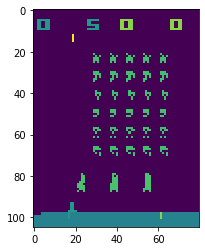

In [88]:
plt.imshow(mem.memory[540][0].reshape((105,80)))